Predictors of Non-Voters in the United States

In [138]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from numpy import linalg as la
import matplotlib.pyplot as plt
import math

In [98]:
df = pd.read_csv('no_voter_data.csv')

In [99]:
# create necessary columns for race 
df['white'] = np.where(df['race'] == 'White', 1, 0)
df['black'] = np.where(df['race'] == 'Black', 1, 0)
df['other/mixed'] = np.where(df['race'] == 'Other/Mixed', 1, 0)
df['hispanic'] = np.where(df['race'] == 'Hispanic', 1, 0)

In [100]:
# gender 
df['gender'] = np.where(df['gender'] == 'Female', 1, 0)

In [101]:
# income category
new_label = {"income_cat": {"Less than $40k":1, 
            "$40-75k":2, 
            "$75-125k":3,
            "$125k or more":4}}
df.replace(new_label, inplace = True)

In [102]:
# education category
new_label = {"educ": {"High school or less":1, 
            "Some college":2, 
            "College":3}}
df.replace(new_label, inplace = True)

In [103]:
# voter category data manipulations
new_label = {"voter_category": {"always":3, "sporadic":2, "rarely/never":1}}
df.replace(new_label, inplace = True)

In [104]:
# DROPPP
df = df.drop(["race", "RespId", "weight"], axis=1)
# fill NA's 
df_2 = df.fillna(0)

In [106]:
y = df_2["voter_category"]

In [107]:
X = df_2.drop("voter_category", axis=1)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [109]:
# Truncated SVD
# use different # of cols and find which # minimizes error
def truncated_svd(X, y):
    svd_errors = []
    w_hats_svd = []
    _, p = X.shape
    u, s, vt = la.svd(X)
    sigma = np.zeros(X.shape)
    sigma1 = sigma.copy()

    for i in range(p):
        s1 = s[:i+1]
        np.fill_diagonal(sigma, np.append(s1, np.zeros(p - i + 1)))
        sigma_inv = la.pinv(sigma)
        w_hat_svd = vt.T@sigma_inv@u.T@y
        w_hats_svd.append(w_hat_svd)
        y_hat_svd = X@w_hat_svd
        svd_errors.append(np.mean(y - y_hat_svd)**2)

    best_param_svd = svd_errors.index(min(svd_errors))
    return best_param_svd, w_hats_svd[best_param_svd]

In [112]:
svd_best_num_col, svd_whats = truncated_svd(X_train, y_train)

In [114]:
# Ridge Regression
def rls(X, y, lambda_vals):
    
    #### RLS ####
    w_hat_lst = []
    errors_lst = []
    u, s, vt = la.svd(X)
    sigma = np.zeros(X.shape) # n x p
    sigma1 = sigma.copy() #creating copy 
    np.fill_diagonal(sigma1, s)
            
    for l, val in enumerate(lambda_vals):
        w_hat = la.inv(vt.T@sigma1.T@sigma1@vt + val)@vt.T@sigma1.T@u.T@y
        w_hat_lst.append(w_hat)

        y_tilde = X@w_hat
        # error = la.norm(y - y_tilde)
        error = np.mean((y_tilde - y)**2)
        errors_lst.append(error)

    best_param_index = errors_lst.index(min(errors_lst))
    best_w = w_hat_lst[best_param_index]
    best_lambda = lambda_vals[best_param_index]
    return best_lambda, best_w 


In [115]:
lambda_vals = np.array([0, 0.001, 0.01, 0.1, 0.5, 1, 2, 4, 8, 16, 32, 64])

rls_best_lambda, rls_whats = rls(X, y, lambda_vals)

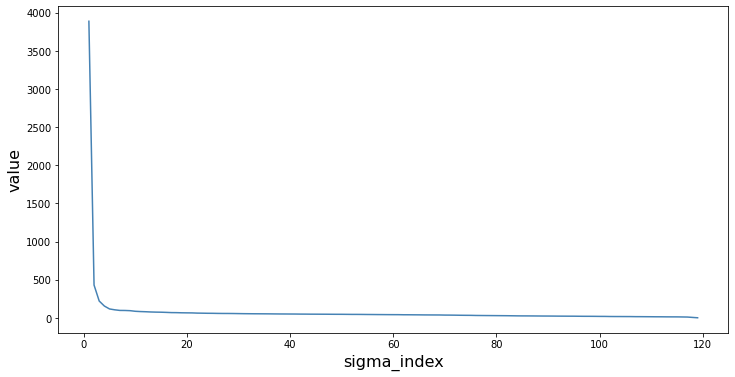

In [124]:
# PCA
u,s,vh = np.linalg.svd(X_train ,full_matrices=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
ax.plot(range(1,s.shape[0]+1), s, color="steelblue", label='sigmas')
ax.set_xlabel("sigma_index", fontsize=16)
ax.set_ylabel("value", fontsize=16)
plt.show()

# first 3 sigmas seem to be the most important; we will solve for 3 principle components

In [125]:
# calculate principal components
pc = X_train@vh[:3,:].T
z3 = pc

# use 3 PC to compute least sqaures 
w = np.linalg.inv(z3.T@z3)@z3.T@y_train
y_pred = z3@w
acc_train = np.mean((y_pred - y_train)**2)
acc_train = la.norm(y_pred - y_train)
print("training error distance:", acc_train)

# What to make of this? 
# Watch a video? lmao

training error distance: 50.142760706404495


In [ ]:
# SVM
# sigma_sq is our parameter



In [127]:
# Kernal Ridge
def kernel_ridge(X, y, sigma, lam):
    n, p = X.shape
    norms2 = (np.array(la.norm(X, axis =1)).T)**2 # squared norm of each training sample
    innerProds = X@X.T

    # squared distances between each pair of training samples
    dist2 = np.matrix(norms2).T@np.ones([1, n]) + np.ones([n, 1])@np.matrix(norms2) - 2*innerProds 
    K = np.exp(-dist2/(2*sigma))
    alpha = (la.inv(K + lam*np.identity(n))@y)
    yhat = K@alpha.T

    return alpha

In [128]:
# initial sigma/lam
sigma = .05
lam = 1
kr_alpha = kernel_ridge(X_train, y_train, sigma, lam)

In [136]:
# 4668 is the # of training samples; alpha is in R^n 
kr_alpha.shape

(4668,)

In [ ]:
# Logistic Regression



In [177]:
def sigmoid(score, threshold=20.0):
    """
    Sigmoid function with a threshold
    :param score: (float) A real valued number to convert into a number between 0 and 1
    :param threshold: (float) Prevent overflow of exp by capping activation at 20.
    
    :return: (float) sigmoid function result.
    """
    # TODO: Finish this function to restrict the value of the input score and return the output of applying the 
    #       sigmoid function to it (Please do not use external libraries)
    
    if abs(score) > abs(threshold):
        score = math.copysign(threshold,score)

    sigmoid = 1 / (1 + math.exp(-score))
    
    return sigmoid

    
def sigmoid_grad(y, threshold=20.0):
    """
    Derivative/gradient of the sigmoid function.
    :param y: (float) A real valued input for which to compute the derivative.
    :param threshold: (float) Prevent overflow of exp by capping activation at 20.
    
    :return: (float) sigmoid derivative function result.
    """
    # TODO: Finish this function to return the output of applying the gradient of the sigmoid
    # function to the input score (Please do not use external libraries)

    if abs(y) > abs(threshold):
        y = math.copysign(threshold,y)
    deriv = (sigmoid(y)**2)*math.exp(-y)
    
    return deriv
    
def shuffle(X, y):
    """ Shuffle training data """
    shuffled_indices = np.random.permutation(len(y))
    #print("?!", shuffled_indices)
    return X.iloc[shuffled_indices], y.iloc[shuffled_indices]

In [198]:
class LogReg:
    def __init__(self, num_features, eta):
        """
        Create a logistic regression classifier
        :param num_features: (int) The number of features (including bias)
        :param eta: (float) learning rate
        """
        self.w = np.zeros((num_features,1))
        self.eta = eta

    def progress(self, examples_x, examples_y):
        """
        Given a set of examples, compute the probability and accuracy
        :param examples_x: (2D np.ndarray) The features from the dataset to score
        :param examples_y: (1D np.ndarray) The labels from the dataset to score

        :return: (float, float) A tuple of (log probability, accuracy)
        """

        logprob = 0.0
        num_right = 0
        for x_i, y in zip(examples_x, examples_y):
            p = sigmoid(self.w.dot(x_i))
            if y == 1:
                logprob += math.log(p)
            else:
                logprob += math.log(1.0 - p)

            # Get accuracy
            if abs(y - p) <= 0.5:
                num_right += 1

        return logprob, float(num_right) / float(len(examples_y))

    def sgd_update(self, x_i, y, lam=0.0):
        """
        Compute a stochastic gradient update to improve the log likelihood.
        :param x_i: (1D np.ndarray) The features of the example to take the gradient with respect to
        :param y: (float) The target output of the example to take the gradient with respect to
        :param lam: (float) regularization term. Default is zero; only used in Part 2D.
        
        :return: (1D np.ndarray) Return the new value of the regression coefficients
        """

        # compute pi
        print("xi", x_i)
        pi = sigmoid(self.w.dot(x_i))
        print("pi:", pi)
        
        action = 2 * lam * self.w[1:]

        # insert b_0
        action = np.insert(action,0,0) 
        self.w = self.w + self.eta * ((y - pi) * x_i - action)
        
        return self.w

In [172]:
y_train.iloc[[2559]]

5283    1
Name: voter_category, dtype: int64

In [196]:
def train(epochs, eta, store_epoch, lam=1e-5, decay=0):
    """
    Train a LogReg object for a set number of epochs with a given eta.
    
    :param epochs: (int) total number of training epochs
    :param eta: (float) learning rate
    :param store_epoch: (int) store training and test accuracies every store_epoch epochs
    :param lam: (float) weight given to regularization term. Default 0. Only used in Part 2D. 
    :param decay: (float) Used to update learning rate during training (Part 3). 
                  Equals 0 when learning rate is constant throughout training (Part 2). 
                  
    :return (train_accuracy_array, test_accuracy_array, learning_rates): tuple of (List, List, List)
        :train_accuracy_array: training accuracy after every store_epoch epochs
        :test_accuracy_array: test accuracy after every store_epoch epochs
        :learning_rates: learning rate after every store_epoch epochs. All values in this list 
                         will be the same if decay = 0 (Only required for Part 2F)
    
        Example: With epochs = 30 and store_epoch = 10, only store accuracies after epochs = 10, 20, and 30.
    """
    
    lr = LogReg(X_train.shape[1], eta)

    #assert dataset_handler.train_x.shape == (1105, 60) 
    #assert dataset_handler.test_x.shape == (277, 60) 
    
    train_accuracy_array = []
    test_accuracy_array = []
    learning_rates = []
    
    for epoch in range(epochs):
        # TODO: Finish the code to loop over the training data and perform a stochastic
        # gradient descent update on each training example.

        # NOTE: It may be helpful to call upon the 'progress' method in the LogReg class
        # to make sure the algorithm is truly learning properly on both training and test data
        
        # update learning rate
        lr.eta = lr.eta / (1 + decay * epoch)
        
        # shuffle data
        x, y = shuffle(X_train, y_train)
        print("got here?")
        
        # go through entire training data
        for i, x_i in enumerate(x):
            new_x = x[x_i].values.reshape((1,x.shape[0]))        
            lr.sgd_update(new_x, y.iloc[i], lam)
        
        # store prorgress for each store_epoch
        if epoch % store_epoch == 0:
            _, train_accuracy = lr.progress(x, y)
            train_accuracy_array.append(train_accuracy)
            #_, test_accuracy = lr.progress(dataset_handler.test_x, dataset_handler.test_y)
            # test_accuracy_array.append(test_accuracy)
            learning_rates.append(lr.eta)
            
        
    return train_accuracy_array, learning_rates
    #test_accuracy_array,

In [199]:
eta  = 1e-4
epochs = 300
store_epoch = 50
train_acc, _ = train(epochs, eta, store_epoch)

for i in range(len(train_acc)):
    print("\ntrain accuracy after {} epochs: {}".format((i+1)*store_epoch, train_acc[i]))
    #print("test accuracy after {} epochs: {}".format((i+1)*store_epoch, test_acc[i]))


got here?
xi [[1 1 1 ... 1 1 1]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Random Forest


In [162]:
lst = shuffle(X_train,y_train)
X_train.iloc[lst]

?! [4235 3323 2930 ... 2750 1493 3967]


,Q1,Q2_1,Q2_2,Q2_3,Q2_4,Q2_5,Q2_6,Q2_7,Q2_8,Q2_9,...,Q32,Q33,ppage,educ,gender,income_cat,white,black,other/mixed,hispanic
512,1,1,2,1,1,1,2,1,1,1,...,1.0,0.0,73,3,0,2,0,1,0,0
4484,1,1,1,1,1,1,1,1,1,1,...,0.0,0.0,73,2,1,4,1,0,0,0
1939,1,1,2,2,1,1,1,1,1,1,...,0.0,0.0,29,2,1,2,1,0,0,0
1111,1,1,2,1,3,1,3,1,1,1,...,1.0,0.0,74,2,0,1,0,1,0,0
4455,1,4,2,2,4,1,3,3,1,2,...,0.0,2.0,37,3,0,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,1,1,4,3,3,1,2,1,1,4,...,0.0,1.0,64,1,1,2,1,0,0,0
532,1,1,1,1,2,1,1,1,1,2,...,0.0,0.0,57,3,0,4,1,0,0,0
303,1,1,1,2,2,1,1,2,1,4,...,0.0,0.0,41,2,0,4,1,0,0,0
4832,1,1,1,1,1,1,1,1,2,2,...,0.0,0.0,45,1,0,3,1,0,0,0
